# Gaussian processes 101

In this notebook, I demonstrate the very basics of GPs: what samples look like, and how to interpret conditioning. All theoretical matters like existence and unicity are swept under the rag.

In [1]:
%pylab inline
figsize(8,5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import necessary libraries
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import matplotlib.pyplot as plt

$f\sim \text{GP}(\mu, K)$ means that $\forall p\in\mathbb{N}$, $\forall x_1,\dots,x_p\in\mathbb{R}^d$, 
$$
(f(x_1),\dots,f(x_p))^T\sim \mathcal{N}({\bf m},{\bf K})
$$
where ${\bf m} = (\mu(x_1),\dots,\mu(x_p))^T$ and ${\bf K}=((K(x_i,x_j))_{1\leq i,j\leq p}$.

This is what I mean when I say that
* a GP is specified through its marginals. 
* a GP is specified through two parameters $\mu$ and $K$. These parameters are functions. $K$ is called a positive definite kernel, which means that we require the matrix ${\bf K}$ to be semidefinite positive for every choice of $x_1,\dots,x_p$. Our Gaussian marginals are thus well-defined.
* Think of $(f(x))_{x\in\mathbb{R}^d}$ as an infinite-dimensional Gaussian vector indexed by $x$.

In [3]:
# an example kernel: the squared exponential kernel
def seKernel(x,y,a,ell):
    return a*np.exp(-npl.norm(x-y)**2/2/ell**2)

## Visualizing GP samples

To visualize samples from a GP with zero mean and any kernel $K$, you first need to decide where you want to evaluate $f$, say on a regular grid on [0,1]

In [4]:
n = 1000
grid = np.linspace(0,1,n)

Then, drawing a sample $f\sim\text{GP}(0,K)$ and observing its evaluation at the points $x_1,\dots,x_n$ of the grid has *by definition* the same distribution as drawing a multivariate Gaussian $\mathcal{N}(0,{\bf K})$, with ${\bf K}=((K(x_i,x_j))$.

In [5]:
a = 1 # amplitude parameter
ell = .1 # lengthscale parameter
K = np.array([[seKernel(x,y,a,ell) for x in grid] for y in grid]).reshape((n,n))

Now drawing a ${\bf f}\sim \mathcal{N}(0,{\bf K})$ is equivalent to first drawing ${\bf u}\sim\mathcal{N}(0,{\bf I})$, computing the Cholesky decomposition ${\bf K}={\bf L}{\bf L}^T$, and setting ${\bf f} = {\bf L}{\bf u}$. 

Exercise: prove that this indeed yields ${\bf f}\sim \mathcal{N}(0,{\bf K})$.

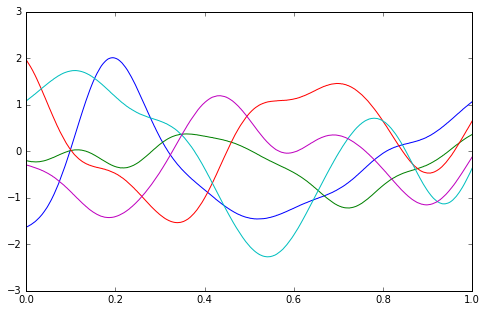

In [8]:
eps = 1e-6 # add a small positive "nugget" to avoid zero eigenvalues
L = npl.cholesky(K+eps*np.eye(n)) 
numSamples = 5

for _ in range(numSamples):
    u = npr.randn(n)
    plt.plot(grid, np.dot(L,u))
plt.show()    

Remark how general the sample functions look when you vary $a$ and $\ell$. Compare that to the random functions encoded in parametric linear regression with a Gaussian prior on the weights:

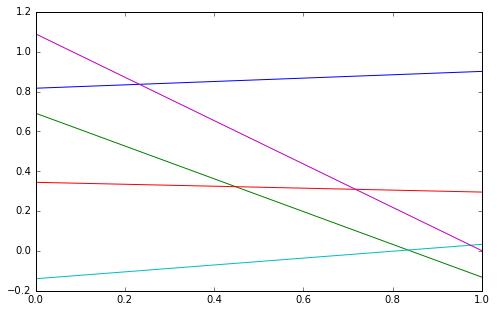

In [9]:
for _ in range(numSamples):
    w = npr.randn()
    plt.plot(grid, npr.randn() + np.dot(w, grid)) # adding an intercept
plt.show()    

Same thing for polynomial features, say $\phi(x) = (1,x,x^2,x^3)$

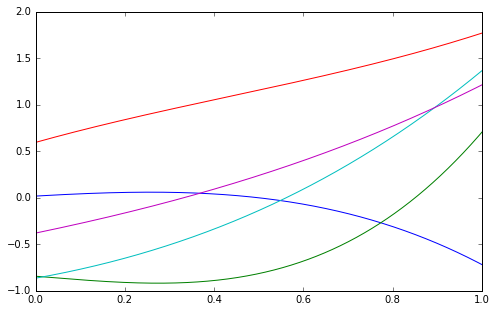

In [11]:
p = 4 # number of features
for _ in range(numSamples):
    w = npr.randn(p)
    Phi = np.array([[1,x,x**2,x**3] for x in grid])
    plt.plot(grid, np.dot(Phi, w))
plt.show()    

## Understanding conditioning

GPs are conjugate is the following sense: Assume $f\sim\text{GP}(0,K)$, and let $$y_i = f(x_i)+\epsilon_i, \forall 1\leq i\leq n,$$ with $\epsilon_i$ i.i.d. $\mathcal{N}(0,\sigma^2)$. Then 
$$f\vert (x_1,y_1),\dots (x_n,y_n) \sim \text{GP}(\mu_{\text{post}}, K_{\text{post}}),$$ with
$$ \mu_{\text{post}}(x) = {\bf k(x)}^T({\bf K}+\sigma^2{\bf I})^{-1} {\bf y},$$
$$ K_{\text{post}}(x,x') = K(x,y) - {\bf k(x)}^T({\bf K}+\sigma^2{\bf I})^{-1} {\bf k}(x'),$$
where
${\bf k}(x) = (K(x,x_1),\dots, K(x,x_n))^T$ and as always ${\bf K} = ((K(x_i,x_j))$.


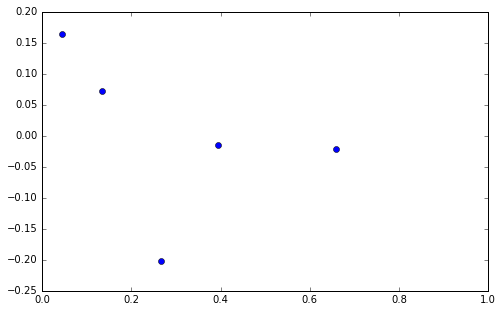

In [12]:
# Let us assume we have some (x,y) data
n = 5
xTrain = npr.rand(n)
yTrain = npr.rand(n)
yTrain = yTrain - np.mean(yTrain) # subtract the mean to back GP(0,K) assumption
plt.plot(xTrain, yTrain, 'o')
plt.xlim([0,1])
plt.show()

In [13]:
a = 1 # amplitude parameter
ell = .1 # lengthscale parameter
sigma = .05
K = np.array([[seKernel(x,z,a,ell) for x in xTrain] for z in xTrain]).reshape((n,n))
L = npl.cholesky(K+sigma**2*np.eye(n))
invK = np.dot(npl.inv(L).transpose(), npl.inv(L))

Let us just check our inversion went right

In [14]:
print("Test", np.max( np.abs( np.dot(K+sigma**2*np.eye(n),invK) - np.eye(n) ))<1e-5)

Test True


In [15]:
# Define posterior mu and K, with the prior kernel 
# assumed squared-exponential

def muPost(x):
    k = np.array([seKernel(x,xi,a,ell) for xi in xTrain])
    return np.dot(np.dot(k, invK), yTrain)

def kernelPost(x, z):
    kx = np.array([seKernel(x,xi,a,ell) for xi in xTrain])
    kz = np.array([seKernel(z,xi,a,ell) for xi in xTrain])
    return seKernel(x,z,a,ell) - np.dot(kx, np.dot(invK, kz))

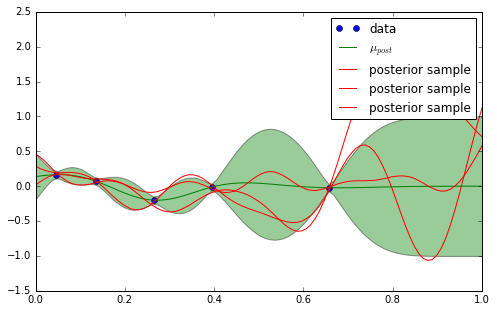

In [18]:
# Now we visualize the posterior marginal confidence intervals
plt.plot(xTrain, yTrain, 'o', markersize=6, label="data")
grid = np.linspace(0,1,100)
gridSize = len(grid)

# Plot the mean function of the posterior GP
m = np.array([muPost(x) for x in grid])
plt.plot(grid, m, 'g', label="$\mu_{post}$")

# Add the square root of the posterior kernel
s = np.sqrt(np.array([kernelPost(x,x) for x in grid]))
plt.fill_between(grid, m-s, m+s, facecolor='green', alpha = .4, interpolate=True)

# Uncomment the following paragraph to add a few samples of the posterior GP
KPost = np.array([[kernelPost(x,z) for x in grid] for z in grid
                ]).reshape((gridSize,gridSize))
LPost = npl.cholesky(KPost+eps*np.eye(gridSize))
for _ in range(3):
    plt.plot(grid, m+np.dot(LPost,npr.randn(gridSize)), 'r', label="posterior sample")

plt.xlim([0,1])
plt.legend()
plt.show()

Observe how samples are constrained around the data points. Note also that there is no reason why samples should remain confined in the green area: the green area is a collection of marginal confidence intervals, not a confidence band (why?).